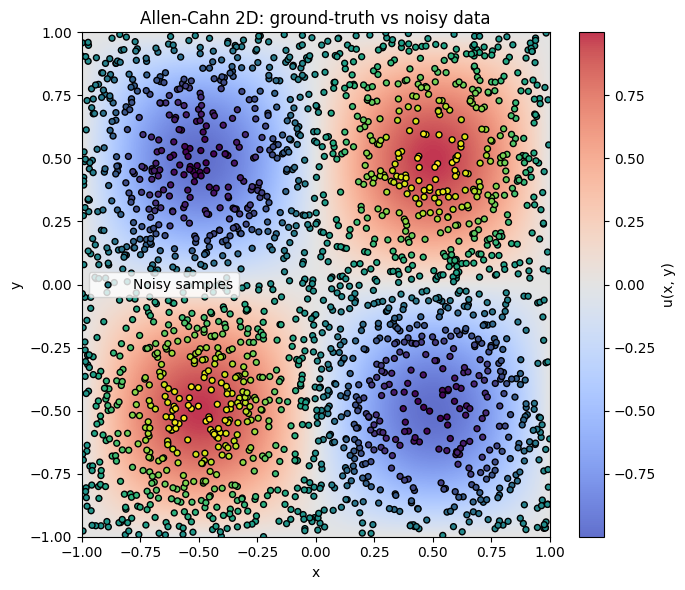

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────


data_noise = 0.001
N_train = 2000
N_test = 200
N_calib = 1000
colloc_pt_num = 1000

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)

alphas = torch.linspace(0.05, 0.99, 10)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────
from utils_tools.utils_result_viz import plot_truth_and_samples_2D

# Dense grid for nice plotting
def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


plot_truth_and_samples_2D(
    X_train, Y_train, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


In [ ]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random


# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_hmc import HMCBPINN

# CP
from utils_uqmd.utils_uq_cp import CP


# Model
hmc_model = HMCBPINN(
    pde_class=pde, input_dim=2, hidden_dims=[64, 64 ,64],
    output_dim=1, act_func=nn.Tanh, prior_std=1.0,
    step_size=1e-3, leapfrog_steps=5
)

# Fitting args
fit_args = {
    "coloc_pt_num": colloc_pt_num,
    "X_train": X_train,
    "Y_train": Y_train
}
fit_kwargs_grid = {
    "λ_pde": [1.0],
    "λ_bc": [5.0, 10.0, 15.0],
    "λ_data": [1.0, 2.0, 5.0],
    "epochs": [10000],
    "lr": [1e-3],
    "hmc_samples": [10000],
    "burn_in":[5000],
    "step_size": [1e-3],
    "leapfrog_steps": [10],
}

baseline_pred_kwargs = { "n_samples": 6000 }
cp_pred_kwargs = {
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 100
}
cp_coverage_args = {
    "alphas": alphas, "X_test": X_test, "Y_test": Y_test,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "X_train": X_train, "Y_train": Y_train,
    "heuristic_u": "raw_std", "k": 100
}
baseline_coverage_args = {
    "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}


# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------
n_grid = 100
x = torch.linspace(domain[0][0],domain[0][1], n_grid)
y = torch.linspace(domain[1][0],domain[1][1], n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


# --------------------------------------------
# Start hyperparameter tuning 
# --------------------------------------------
from utils_tools.utils_tuning import hyperparameter_tuning
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
from utils_uqmd.utils_uq_cp import CP
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, hmc_test_uncertainties

hyperparameter_tuning(
    plot_title="HMC CP Model", # Change this
    # Model Fitting & Predicting
    uqmodel=hmc_model,  # Change this
    alpha=0.05, 
    X_test=grid_test, Y_test=Y_test, 
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    # Coverage Test
    baseline_testing_args=baseline_coverage_args, cp_testing_args=cp_coverage_args,
    baseline_test_uncertainties=hmc_test_uncertainties, # Change this
    # Plotting function
    plotting_func=plot_2D_comparison_with_coverage, # Chang if dimension changes
    save_dir="2dallencahn_hmc_cp_p3", # Change this
    X_validation=X_test, Y_validation=Y_test,
)

Using device: cpu
Using device: cpu

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 5.0, 'λ_data': 1.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
MAP:   5%|▌         | 512/10000 [00:05<01:40, 94.36it/s, loss=3.06e+00]

[MAP] epoch    500  −logPost=3.223e+00  Data=2.496e-01  PDE=5.279e-01  IC=0.000e+00  BC=5.049e-06


MAP:  10%|█         | 1016/10000 [00:11<01:37, 91.82it/s, loss=9.90e-01]

[MAP] epoch   1000  −logPost=9.950e-01  Data=2.495e-01  PDE=5.052e-01  IC=0.000e+00  BC=4.909e-05


MAP:  15%|█▌        | 1514/10000 [00:16<01:31, 92.94it/s, loss=7.78e-01]

[MAP] epoch   1500  −logPost=7.802e-01  Data=2.495e-01  PDE=5.190e-01  IC=0.000e+00  BC=3.028e-05


MAP:  20%|██        | 2011/10000 [00:22<01:25, 93.58it/s, loss=7.86e-01]

[MAP] epoch   2000  −logPost=7.830e-01  Data=2.495e-01  PDE=5.332e-01  IC=0.000e+00  BC=2.863e-05


MAP:  25%|██▌       | 2511/10000 [00:27<01:19, 93.93it/s, loss=7.61e-01]

[MAP] epoch   2500  −logPost=7.840e-01  Data=2.495e-01  PDE=5.345e-01  IC=0.000e+00  BC=4.109e-05


MAP:  30%|███       | 3011/10000 [00:32<01:14, 93.27it/s, loss=7.60e-01]

[MAP] epoch   3000  −logPost=7.753e-01  Data=2.496e-01  PDE=5.258e-01  IC=0.000e+00  BC=2.306e-05


MAP:  35%|███▌      | 3511/10000 [00:38<01:09, 92.82it/s, loss=7.85e-01]

[MAP] epoch   3500  −logPost=7.722e-01  Data=2.496e-01  PDE=5.226e-01  IC=0.000e+00  BC=5.337e-06


MAP:  40%|████      | 4011/10000 [00:43<01:05, 91.60it/s, loss=7.77e-01]

[MAP] epoch   4000  −logPost=8.027e-01  Data=2.496e-01  PDE=5.531e-01  IC=0.000e+00  BC=1.904e-05


MAP:  45%|████▌     | 4511/10000 [00:48<00:57, 94.97it/s, loss=7.91e-01]

[MAP] epoch   4500  −logPost=7.493e-01  Data=2.495e-01  PDE=4.997e-01  IC=0.000e+00  BC=2.569e-05


MAP:  50%|█████     | 5011/10000 [00:54<00:53, 93.84it/s, loss=7.87e-01]

[MAP] epoch   5000  −logPost=7.861e-01  Data=2.496e-01  PDE=5.365e-01  IC=0.000e+00  BC=1.901e-05


MAP:  55%|█████▌    | 5511/10000 [00:59<00:48, 93.25it/s, loss=7.92e-01]

[MAP] epoch   5500  −logPost=7.938e-01  Data=2.495e-01  PDE=5.442e-01  IC=0.000e+00  BC=5.516e-05


MAP:  60%|██████    | 6011/10000 [01:04<00:42, 93.33it/s, loss=7.74e-01]

[MAP] epoch   6000  −logPost=7.832e-01  Data=2.496e-01  PDE=5.336e-01  IC=0.000e+00  BC=1.690e-05


MAP:  65%|██████▌   | 6511/10000 [01:10<00:37, 94.20it/s, loss=7.61e-01]

[MAP] epoch   6500  −logPost=7.796e-01  Data=2.495e-01  PDE=5.300e-01  IC=0.000e+00  BC=3.648e-05


MAP:  70%|███████   | 7011/10000 [01:15<00:31, 94.48it/s, loss=7.76e-01]

[MAP] epoch   7000  −logPost=7.802e-01  Data=2.494e-01  PDE=5.307e-01  IC=0.000e+00  BC=8.207e-05


MAP:  75%|███████▌  | 7511/10000 [01:20<00:26, 93.62it/s, loss=7.56e-01]

[MAP] epoch   7500  −logPost=7.653e-01  Data=2.494e-01  PDE=5.157e-01  IC=0.000e+00  BC=8.083e-05


MAP:  80%|████████  | 8011/10000 [01:26<00:21, 93.31it/s, loss=7.82e-01]

[MAP] epoch   8000  −logPost=7.772e-01  Data=2.496e-01  PDE=5.276e-01  IC=0.000e+00  BC=1.725e-05


MAP:  85%|████████▌ | 8511/10000 [01:31<00:15, 93.45it/s, loss=7.87e-01]

[MAP] epoch   8500  −logPost=7.805e-01  Data=2.495e-01  PDE=5.309e-01  IC=0.000e+00  BC=3.222e-05


MAP:  90%|█████████ | 9011/10000 [01:37<00:10, 92.58it/s, loss=7.88e-01]

[MAP] epoch   9000  −logPost=7.681e-01  Data=2.495e-01  PDE=5.185e-01  IC=0.000e+00  BC=3.035e-05


MAP:  95%|█████████▌| 9511/10000 [01:42<00:05, 93.68it/s, loss=7.77e-01]

[MAP] epoch   9500  −logPost=7.759e-01  Data=2.495e-01  PDE=5.263e-01  IC=0.000e+00  BC=3.835e-05


[MAP] epoch  10000  −logPost=7.584e-01  Data=2.496e-01  PDE=5.088e-01  IC=0.000e+00  BC=1.686e-05


HMC:   5%|▌         | 502/10000 [00:37<11:55, 13.27it/s, acc=0.98]

[HMC] iter    500  acc-rate=0.98


HMC:  10%|█         | 1002/10000 [01:15<11:23, 13.17it/s, acc=0.91]

[HMC] iter   1000  acc-rate=0.91


HMC:  15%|█▌        | 1502/10000 [01:53<10:41, 13.24it/s, acc=0.89]

[HMC] iter   1500  acc-rate=0.89


HMC:  20%|██        | 2002/10000 [02:31<10:00, 13.31it/s, acc=0.88]

[HMC] iter   2000  acc-rate=0.88


HMC:  25%|██▌       | 2502/10000 [03:09<09:36, 13.01it/s, acc=0.85]

[HMC] iter   2500  acc-rate=0.85


HMC:  30%|███       | 3002/10000 [03:47<08:56, 13.04it/s, acc=0.83]

[HMC] iter   3000  acc-rate=0.83


HMC:  35%|███▌      | 3502/10000 [04:25<08:18, 13.04it/s, acc=0.80]

[HMC] iter   3500  acc-rate=0.80


HMC:  40%|████      | 4002/10000 [05:03<07:45, 12.88it/s, acc=0.80]

[HMC] iter   4000  acc-rate=0.80


HMC:  45%|████▌     | 4502/10000 [05:41<06:58, 13.13it/s, acc=0.79]

[HMC] iter   4500  acc-rate=0.79


HMC:  50%|█████     | 5002/10000 [06:19<06:22, 13.07it/s, acc=0.77]

[HMC] iter   5000  acc-rate=0.77


HMC:  55%|█████▌    | 5502/10000 [06:56<05:26, 13.76it/s, acc=0.76]

[HMC] iter   5500  acc-rate=0.76


HMC:  60%|██████    | 6002/10000 [07:32<04:45, 13.99it/s, acc=0.75]

[HMC] iter   6000  acc-rate=0.75


HMC:  65%|██████▌   | 6502/10000 [08:08<04:10, 13.94it/s, acc=0.74]

[HMC] iter   6500  acc-rate=0.74


HMC:  70%|███████   | 7002/10000 [08:43<03:40, 13.58it/s, acc=0.73]

[HMC] iter   7000  acc-rate=0.73


HMC:  75%|███████▌  | 7502/10000 [09:19<02:55, 14.26it/s, acc=0.71]

[HMC] iter   7500  acc-rate=0.71


HMC:  80%|████████  | 8002/10000 [09:55<02:24, 13.82it/s, acc=0.70]

[HMC] iter   8000  acc-rate=0.70


HMC:  85%|████████▌ | 8502/10000 [10:31<01:49, 13.67it/s, acc=0.69]

[HMC] iter   8500  acc-rate=0.69


HMC:  90%|█████████ | 9002/10000 [11:08<01:13, 13.65it/s, acc=0.68]

[HMC] iter   9000  acc-rate=0.68


HMC:  95%|█████████▌| 9502/10000 [11:43<00:35, 14.08it/s, acc=0.67]

[HMC] iter   9500  acc-rate=0.67


[HMC] iter  10000  acc-rate=0.66
Finished HMC: avg acceptance 0.660
Keep 5000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [00:29<00:00,  2.93s/it]



[✅] Data Loss = 8.193e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 5.0, 'λ_data': 2.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 511/10000 [00:04<01:26, 109.95it/s, loss=9.11e+02]

[MAP] epoch    500  −logPost=9.438e+02  Data=2.814e-02  PDE=1.021e-01  IC=0.000e+00  BC=2.478e-02


MAP:  10%|█         | 1012/10000 [00:09<01:21, 110.20it/s, loss=3.90e+02]

[MAP] epoch   1000  −logPost=4.050e+02  Data=9.453e-02  PDE=1.960e-01  IC=0.000e+00  BC=4.939e-02


MAP:  15%|█▌        | 1516/10000 [00:13<01:16, 110.56it/s, loss=1.64e+02]

[MAP] epoch   1500  −logPost=1.708e+02  Data=1.588e-01  PDE=3.287e-01  IC=0.000e+00  BC=4.340e-02


MAP:  20%|██        | 2020/10000 [00:18<01:12, 109.96it/s, loss=6.71e+01]

[MAP] epoch   2000  −logPost=6.981e+01  Data=2.406e-01  PDE=5.310e-01  IC=0.000e+00  BC=9.025e-04


MAP:  25%|██▌       | 2512/10000 [00:22<01:07, 110.97it/s, loss=2.62e+01]

[MAP] epoch   2500  −logPost=2.734e+01  Data=2.494e-01  PDE=5.245e-01  IC=0.000e+00  BC=8.257e-05


MAP:  30%|███       | 3014/10000 [00:27<01:03, 110.12it/s, loss=1.00e+01]

[MAP] epoch   3000  −logPost=1.046e+01  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=5.705e-05


MAP:  35%|███▌      | 3518/10000 [00:31<00:58, 110.57it/s, loss=3.96e+00]

[MAP] epoch   3500  −logPost=4.096e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.422e-05


MAP:  40%|████      | 4022/10000 [00:36<00:54, 110.50it/s, loss=1.84e+00]

[MAP] epoch   4000  −logPost=1.888e+00  Data=2.495e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.843e-05


MAP:  45%|████▌     | 4514/10000 [00:40<00:49, 110.57it/s, loss=1.14e+00]

[MAP] epoch   4500  −logPost=1.152e+00  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.045e-05


MAP:  50%|█████     | 5018/10000 [00:45<00:44, 111.01it/s, loss=8.86e-01]

[MAP] epoch   5000  −logPost=9.192e-01  Data=2.495e-01  PDE=5.515e-01  IC=0.000e+00  BC=4.206e-05


MAP:  55%|█████▌    | 5521/10000 [00:49<00:40, 110.62it/s, loss=7.90e-01]

[MAP] epoch   5500  −logPost=8.418e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=2.696e-06


MAP:  60%|██████    | 6012/10000 [00:54<00:35, 110.83it/s, loss=7.84e-01]

[MAP] epoch   6000  −logPost=7.702e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.773e-05


MAP:  65%|██████▌   | 6515/10000 [00:58<00:31, 110.56it/s, loss=8.01e-01]

[MAP] epoch   6500  −logPost=7.930e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.612e-05


MAP:  70%|███████   | 7018/10000 [01:03<00:26, 110.52it/s, loss=7.89e-01]

[MAP] epoch   7000  −logPost=7.814e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.248e-05


MAP:  75%|███████▌  | 7522/10000 [01:08<00:22, 110.09it/s, loss=7.71e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.293e-05


MAP:  80%|████████  | 8014/10000 [01:12<00:17, 110.55it/s, loss=7.62e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.519e-05


MAP:  85%|████████▌ | 8518/10000 [01:17<00:13, 110.53it/s, loss=7.42e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.866e-05


MAP:  90%|█████████ | 9019/10000 [01:21<00:08, 110.82it/s, loss=7.56e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.748e-05


MAP:  95%|█████████▌| 9522/10000 [01:26<00:04, 111.32it/s, loss=7.98e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.528e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.422e-05


HMC:   5%|▌         | 502/10000 [00:35<11:14, 14.08it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:09<10:22, 14.45it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:44<10:02, 14.11it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:19<09:27, 14.10it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [02:55<08:56, 13.97it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:30<08:11, 14.25it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:06<07:39, 14.13it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [04:41<07:06, 14.07it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:16<06:28, 14.17it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [05:51<05:49, 14.29it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [06:25<05:05, 14.75it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [06:59<04:39, 14.31it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [07:34<04:05, 14.26it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [08:10<03:39, 13.66it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [08:46<02:59, 13.91it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [09:23<02:26, 13.65it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [09:59<01:48, 13.85it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [10:35<01:10, 14.09it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [11:10<00:34, 14.30it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 10000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [02:04<00:00, 12.49s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 5.0, 'λ_data': 5.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 514/10000 [00:06<02:07, 74.40it/s, loss=9.09e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1008/10000 [00:13<01:54, 78.64it/s, loss=3.82e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1508/10000 [00:20<01:49, 77.53it/s, loss=1.57e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2015/10000 [00:26<01:44, 76.68it/s, loss=6.22e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2514/10000 [00:33<01:37, 76.99it/s, loss=2.32e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3008/10000 [00:40<01:31, 76.67it/s, loss=8.22e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3513/10000 [00:46<01:25, 75.62it/s, loss=2.95e+00]

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4013/10000 [00:53<01:21, 73.39it/s, loss=1.34e+00]

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4507/10000 [01:00<01:14, 73.87it/s, loss=8.91e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5007/10000 [01:06<01:08, 73.38it/s, loss=7.95e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5512/10000 [01:13<01:02, 71.71it/s, loss=8.10e-01]

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6012/10000 [01:19<00:55, 71.91it/s, loss=7.82e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6512/10000 [01:26<00:46, 74.76it/s, loss=7.63e-01]

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7011/10000 [01:33<00:39, 76.49it/s, loss=7.89e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7511/10000 [01:40<00:32, 76.24it/s, loss=7.91e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8009/10000 [01:46<00:26, 76.05it/s, loss=7.96e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8509/10000 [01:53<00:18, 78.69it/s, loss=7.57e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9015/10000 [02:00<00:13, 75.60it/s, loss=7.60e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9515/10000 [02:06<00:06, 76.95it/s, loss=7.83e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:41<13:00, 12.17it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:22<12:11, 12.30it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [02:02<11:23, 12.43it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:41<10:14, 13.01it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [03:20<09:53, 12.64it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [04:00<10:18, 11.31it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:41<08:57, 12.08it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [05:23<08:25, 11.87it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [06:03<07:38, 11.99it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [06:43<06:41, 12.46it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [07:22<05:44, 13.07it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [08:00<05:10, 12.89it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [08:39<04:37, 12.63it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [09:18<04:09, 12.02it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [09:56<03:12, 13.00it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [10:35<02:32, 13.06it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [11:13<01:59, 12.49it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [11:52<01:18, 12.69it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [12:31<00:37, 13.25it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 15000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [01:27<00:00,  8.73s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 10.0, 'λ_data': 1.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 516/10000 [00:04<01:23, 113.93it/s, loss=8.97e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1020/10000 [00:08<01:18, 114.91it/s, loss=3.77e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1512/10000 [00:13<01:14, 114.58it/s, loss=1.55e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2016/10000 [00:17<01:09, 115.37it/s, loss=6.12e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2520/10000 [00:21<01:05, 114.83it/s, loss=2.28e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3012/10000 [00:26<01:00, 114.91it/s, loss=8.08e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3516/10000 [00:30<00:56, 114.46it/s, loss=2.94e+00]

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4020/10000 [00:35<00:51, 115.28it/s, loss=1.32e+00]

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4512/10000 [00:39<00:47, 115.09it/s, loss=9.06e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5016/10000 [00:43<00:43, 114.79it/s, loss=7.84e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5520/10000 [00:48<00:39, 114.65it/s, loss=7.91e-01]

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6012/10000 [00:52<00:35, 113.64it/s, loss=7.76e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6516/10000 [00:56<00:30, 113.53it/s, loss=7.99e-01]

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7020/10000 [01:01<00:26, 114.38it/s, loss=7.89e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7512/10000 [01:05<00:21, 114.40it/s, loss=7.69e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8016/10000 [01:09<00:17, 114.44it/s, loss=7.62e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8520/10000 [01:14<00:12, 114.34it/s, loss=7.42e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9012/10000 [01:18<00:08, 114.59it/s, loss=7.56e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9516/10000 [01:22<00:04, 114.72it/s, loss=7.91e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:34<10:49, 14.61it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:08<10:14, 14.64it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:43<09:47, 14.45it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:18<09:19, 14.30it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [02:52<08:40, 14.40it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:27<08:13, 14.17it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:02<07:26, 14.54it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [04:37<07:05, 14.11it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:12<06:29, 14.13it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [05:47<05:59, 13.91it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [06:22<05:25, 13.81it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [06:58<04:47, 13.90it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [07:34<04:11, 13.94it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [08:10<03:36, 13.82it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [08:46<02:58, 14.01it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [09:22<02:24, 13.86it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [09:57<01:46, 14.07it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [10:33<01:11, 13.97it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [11:10<00:36, 13.65it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 20000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [05:52<00:00, 35.21s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 10.0, 'λ_data': 2.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 512/10000 [00:08<02:28, 63.73it/s, loss=9.12e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1011/10000 [00:15<02:17, 65.23it/s, loss=3.84e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1510/10000 [00:23<02:16, 61.98it/s, loss=1.58e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2007/10000 [00:31<02:05, 63.49it/s, loss=6.25e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2513/10000 [00:39<01:56, 64.52it/s, loss=2.33e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3010/10000 [00:47<01:47, 64.77it/s, loss=8.27e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3509/10000 [00:54<01:44, 61.94it/s, loss=3.00e+00]

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4007/10000 [01:02<01:38, 60.89it/s, loss=1.35e+00]

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4512/10000 [01:10<01:26, 63.47it/s, loss=8.93e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5010/10000 [01:18<01:17, 64.61it/s, loss=8.05e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5507/10000 [01:26<01:10, 64.04it/s, loss=7.74e-01]

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6011/10000 [01:34<01:00, 65.66it/s, loss=7.82e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6510/10000 [01:41<00:53, 64.89it/s, loss=7.94e-01]

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7008/10000 [01:49<00:41, 71.72it/s, loss=7.58e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7512/10000 [01:56<00:35, 70.23it/s, loss=7.68e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8007/10000 [02:03<00:28, 70.96it/s, loss=7.87e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8511/10000 [02:10<00:21, 70.53it/s, loss=7.89e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9007/10000 [02:17<00:13, 71.37it/s, loss=7.60e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9511/10000 [02:23<00:06, 73.65it/s, loss=7.61e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:37<12:30, 12.65it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:14<11:18, 13.26it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:51<10:22, 13.66it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:28<10:01, 13.31it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [03:05<09:23, 13.31it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:42<08:47, 13.28it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:19<07:52, 13.77it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [04:56<07:23, 13.52it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:33<06:41, 13.71it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [06:10<06:00, 13.87it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [06:45<05:09, 14.53it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [07:20<04:22, 15.26it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [07:53<03:52, 15.03it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [08:25<03:12, 15.57it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [08:59<02:59, 13.91it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [09:33<02:14, 14.90it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [10:07<01:43, 14.40it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [10:41<01:07, 14.87it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [11:15<00:34, 14.42it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 25000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [02:18<00:00, 13.90s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 10.0, 'λ_data': 5.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 519/10000 [00:04<01:32, 102.53it/s, loss=9.00e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1015/10000 [00:09<01:26, 104.18it/s, loss=3.79e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1510/10000 [00:14<01:24, 100.51it/s, loss=1.56e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2015/10000 [00:19<01:15, 105.16it/s, loss=6.15e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2510/10000 [00:24<01:13, 101.85it/s, loss=2.29e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3017/10000 [00:29<01:08, 102.18it/s, loss=8.14e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3515/10000 [00:34<00:59, 108.26it/s, loss=2.93e+00]

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4016/10000 [00:38<00:57, 103.99it/s, loss=1.32e+00]

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4517/10000 [00:43<00:51, 105.64it/s, loss=9.10e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5011/10000 [00:48<00:46, 108.36it/s, loss=8.09e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5519/10000 [00:53<00:43, 102.72it/s, loss=7.86e-01]

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6010/10000 [00:57<00:37, 107.01it/s, loss=7.74e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6520/10000 [01:02<00:33, 104.52it/s, loss=7.64e-01]

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7019/10000 [01:07<00:28, 103.09it/s, loss=7.74e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7514/10000 [01:12<00:23, 107.56it/s, loss=7.62e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8015/10000 [01:16<00:19, 104.43it/s, loss=7.74e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8512/10000 [01:21<00:13, 106.47it/s, loss=7.42e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9015/10000 [01:26<00:09, 107.40it/s, loss=7.85e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9515/10000 [01:30<00:04, 104.49it/s, loss=7.92e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:38<11:57, 13.24it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:17<11:52, 12.63it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:55<11:38, 12.17it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:34<10:20, 12.89it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [03:13<09:49, 12.73it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:51<09:27, 12.33it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:30<08:25, 12.85it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [05:09<08:06, 12.34it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:48<06:59, 13.11it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [06:26<06:20, 13.12it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [07:05<06:06, 12.26it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [07:45<05:06, 13.03it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [08:25<04:38, 12.58it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [09:02<03:35, 13.93it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [09:39<03:06, 13.42it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [10:15<02:24, 13.85it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [10:52<01:56, 12.87it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [11:29<01:12, 13.80it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [12:06<00:36, 13.69it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 30000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [09:05<00:00, 54.55s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 15.0, 'λ_data': 1.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 510/10000 [00:06<02:01, 78.10it/s, loss=9.07e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1014/10000 [00:12<01:55, 77.96it/s, loss=3.82e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1509/10000 [00:19<01:49, 77.29it/s, loss=1.57e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2011/10000 [00:25<01:42, 77.61it/s, loss=6.20e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2514/10000 [00:31<01:32, 80.79it/s, loss=2.32e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3008/10000 [00:38<01:29, 78.35it/s, loss=8.22e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3511/10000 [00:44<01:21, 79.42it/s, loss=2.95e+00]

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4013/10000 [00:50<01:15, 79.33it/s, loss=1.34e+00]

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4516/10000 [00:56<01:07, 80.69it/s, loss=9.14e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5009/10000 [01:02<01:05, 76.52it/s, loss=8.04e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5518/10000 [01:08<00:48, 92.45it/s, loss=7.67e-01]

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6016/10000 [01:14<00:43, 92.58it/s, loss=7.87e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6516/10000 [01:19<00:37, 93.52it/s, loss=7.69e-01]

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7016/10000 [01:25<00:32, 91.47it/s, loss=7.62e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7513/10000 [01:30<00:27, 91.05it/s, loss=7.92e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8013/10000 [01:35<00:21, 91.36it/s, loss=7.59e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8510/10000 [01:41<00:16, 90.29it/s, loss=7.74e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9018/10000 [01:46<00:10, 90.85it/s, loss=7.76e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9514/10000 [01:52<00:05, 90.71it/s, loss=7.87e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:36<10:39, 14.86it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:12<11:06, 13.50it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:49<10:19, 13.71it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:25<10:14, 13.02it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [03:02<09:29, 13.17it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:40<08:47, 13.27it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:17<07:58, 13.59it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [04:55<07:43, 12.93it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:32<06:53, 13.31it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [06:10<06:24, 13.01it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [06:44<05:09, 14.54it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [07:17<04:28, 14.91it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [07:50<04:00, 14.54it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [08:25<03:33, 14.06it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [08:59<02:49, 14.76it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [09:34<02:17, 14.52it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [10:09<01:44, 14.38it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [10:44<01:09, 14.30it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [11:19<00:34, 14.64it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 35000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [05:13<00:00, 31.35s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 15.0, 'λ_data': 2.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 510/10000 [00:05<01:42, 92.51it/s, loss=9.03e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1016/10000 [00:10<01:32, 96.68it/s, loss=3.79e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1518/10000 [00:15<01:28, 95.40it/s, loss=1.56e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2011/10000 [00:21<01:26, 92.16it/s, loss=6.18e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2514/10000 [00:26<01:16, 97.34it/s, loss=2.30e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3013/10000 [00:31<01:10, 98.66it/s, loss=8.14e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3518/10000 [00:36<01:05, 98.86it/s, loss=2.92e+00] 

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4019/10000 [00:41<00:59, 99.97it/s, loss=1.32e+00] 

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4516/10000 [00:46<00:54, 101.22it/s, loss=9.10e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5011/10000 [00:51<00:47, 106.11it/s, loss=8.09e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5518/10000 [00:56<00:41, 106.89it/s, loss=7.95e-01]

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6013/10000 [01:01<00:38, 104.39it/s, loss=7.74e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6519/10000 [01:05<00:34, 99.74it/s, loss=7.64e-01] 

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7014/10000 [01:10<00:29, 101.08it/s, loss=7.80e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7520/10000 [01:15<00:24, 101.69it/s, loss=7.87e-01]

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8014/10000 [01:20<00:19, 99.62it/s, loss=7.80e-01] 

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8518/10000 [01:25<00:14, 100.08it/s, loss=7.84e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9012/10000 [01:30<00:09, 100.01it/s, loss=7.89e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9518/10000 [01:35<00:04, 100.62it/s, loss=7.92e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:36<11:26, 13.83it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:12<10:39, 14.06it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:47<09:59, 14.18it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:22<09:16, 14.38it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [02:57<08:35, 14.55it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:32<08:02, 14.50it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:06<07:30, 14.44it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4002/10000 [04:41<07:00, 14.25it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:14<06:13, 14.72it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [05:48<05:38, 14.75it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [06:20<04:36, 16.28it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [06:50<03:50, 17.35it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [07:19<03:22, 17.30it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [07:49<03:01, 16.52it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [08:18<02:27, 16.95it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [08:48<01:55, 17.32it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [09:18<01:28, 16.94it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [09:48<01:00, 16.54it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [10:17<00:30, 16.34it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 40000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [04:51<00:00, 29.11s/it]



[✅] Data Loss = 8.639e-01

[🔎] Trying: {'λ_pde': 5.0, 'λ_bc': 15.0, 'λ_data': 5.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15}

[🟠] Training...


MAP:   5%|▌         | 510/10000 [00:05<01:41, 93.06it/s, loss=9.04e+02]

[MAP] epoch    500  −logPost=9.312e+02  Data=2.054e-02  PDE=8.325e-02  IC=0.000e+00  BC=3.534e-02


MAP:  10%|█         | 1011/10000 [00:11<01:43, 86.47it/s, loss=3.81e+02]

[MAP] epoch   1000  −logPost=3.920e+02  Data=7.002e-02  PDE=1.277e-01  IC=0.000e+00  BC=3.893e-02


MAP:  15%|█▌        | 1517/10000 [00:16<01:35, 89.20it/s, loss=1.57e+02]

[MAP] epoch   1500  −logPost=1.617e+02  Data=1.831e-01  PDE=3.858e-01  IC=0.000e+00  BC=2.471e-02


MAP:  20%|██        | 2014/10000 [00:21<01:26, 92.37it/s, loss=6.18e+01]

[MAP] epoch   2000  −logPost=6.401e+01  Data=2.486e-01  PDE=5.452e-01  IC=0.000e+00  BC=6.576e-05


MAP:  25%|██▌       | 2514/10000 [00:27<01:16, 98.27it/s, loss=2.30e+01]

[MAP] epoch   2500  −logPost=2.392e+01  Data=2.498e-01  PDE=5.243e-01  IC=0.000e+00  BC=1.390e-05


MAP:  30%|███       | 3016/10000 [00:32<01:12, 96.82it/s, loss=8.13e+00]

[MAP] epoch   3000  −logPost=8.512e+00  Data=2.495e-01  PDE=5.405e-01  IC=0.000e+00  BC=3.960e-05


MAP:  35%|███▌      | 3510/10000 [00:37<01:09, 93.01it/s, loss=2.96e+00]

[MAP] epoch   3500  −logPost=3.049e+00  Data=2.495e-01  PDE=5.139e-01  IC=0.000e+00  BC=6.280e-05


MAP:  40%|████      | 4013/10000 [00:43<01:04, 92.70it/s, loss=1.32e+00]

[MAP] epoch   4000  −logPost=1.360e+00  Data=2.496e-01  PDE=5.291e-01  IC=0.000e+00  BC=2.041e-05


MAP:  45%|████▌     | 4510/10000 [00:48<01:00, 90.21it/s, loss=8.75e-01]

[MAP] epoch   4500  −logPost=9.077e-01  Data=2.495e-01  PDE=5.370e-01  IC=0.000e+00  BC=4.366e-05


MAP:  50%|█████     | 5009/10000 [00:53<00:54, 91.07it/s, loss=7.94e-01]

[MAP] epoch   5000  −logPost=8.204e-01  Data=2.495e-01  PDE=5.516e-01  IC=0.000e+00  BC=4.765e-05


MAP:  55%|█████▌    | 5514/10000 [00:59<00:47, 93.76it/s, loss=7.67e-01] 

[MAP] epoch   5500  −logPost=8.086e-01  Data=2.497e-01  PDE=5.568e-01  IC=0.000e+00  BC=7.379e-07


MAP:  60%|██████    | 6012/10000 [01:04<00:41, 96.67it/s, loss=7.87e-01]

[MAP] epoch   6000  −logPost=7.615e-01  Data=2.495e-01  PDE=5.118e-01  IC=0.000e+00  BC=2.692e-05


MAP:  65%|██████▌   | 6515/10000 [01:09<00:38, 90.54it/s, loss=7.78e-01]

[MAP] epoch   6500  −logPost=7.913e-01  Data=2.495e-01  PDE=5.418e-01  IC=0.000e+00  BC=4.687e-05


MAP:  70%|███████   | 7009/10000 [01:15<00:31, 95.83it/s, loss=7.62e-01]

[MAP] epoch   7000  −logPost=7.812e-01  Data=2.495e-01  PDE=5.317e-01  IC=0.000e+00  BC=6.323e-05


MAP:  75%|███████▌  | 7517/10000 [01:20<00:28, 88.13it/s, loss=7.92e-01] 

[MAP] epoch   7500  −logPost=7.397e-01  Data=2.496e-01  PDE=4.901e-01  IC=0.000e+00  BC=2.297e-05


MAP:  80%|████████  | 8009/10000 [01:26<00:21, 92.62it/s, loss=7.59e-01]

[MAP] epoch   8000  −logPost=7.713e-01  Data=2.495e-01  PDE=5.217e-01  IC=0.000e+00  BC=5.555e-05


MAP:  85%|████████▌ | 8514/10000 [01:31<00:16, 88.02it/s, loss=7.72e-01]

[MAP] epoch   8500  −logPost=7.828e-01  Data=2.496e-01  PDE=5.332e-01  IC=0.000e+00  BC=1.846e-05


MAP:  90%|█████████ | 9019/10000 [01:36<00:10, 95.94it/s, loss=7.77e-01]

[MAP] epoch   9000  −logPost=7.602e-01  Data=2.495e-01  PDE=5.106e-01  IC=0.000e+00  BC=3.761e-05


MAP:  95%|█████████▌| 9510/10000 [01:42<00:05, 97.26it/s, loss=7.45e-01]

[MAP] epoch   9500  −logPost=7.786e-01  Data=2.495e-01  PDE=5.290e-01  IC=0.000e+00  BC=2.529e-05


[MAP] epoch  10000  −logPost=7.836e-01  Data=2.495e-01  PDE=5.341e-01  IC=0.000e+00  BC=5.430e-05


HMC:   5%|▌         | 502/10000 [00:37<10:48, 14.64it/s, acc=0.99]

[HMC] iter    500  acc-rate=0.99


HMC:  10%|█         | 1002/10000 [01:14<12:08, 12.34it/s, acc=0.93]

[HMC] iter   1000  acc-rate=0.93


HMC:  15%|█▌        | 1502/10000 [01:51<11:28, 12.35it/s, acc=0.92]

[HMC] iter   1500  acc-rate=0.92


HMC:  20%|██        | 2002/10000 [02:29<09:43, 13.71it/s, acc=0.91]

[HMC] iter   2000  acc-rate=0.91


HMC:  25%|██▌       | 2502/10000 [03:06<08:59, 13.90it/s, acc=0.87]

[HMC] iter   2500  acc-rate=0.87


HMC:  30%|███       | 3002/10000 [03:43<09:35, 12.16it/s, acc=0.84]

[HMC] iter   3000  acc-rate=0.84


HMC:  35%|███▌      | 3502/10000 [04:20<07:50, 13.81it/s, acc=0.81]

[HMC] iter   3500  acc-rate=0.81


HMC:  40%|████      | 4000/10000 [04:58<07:33, 13.24it/s, acc=0.78]

[HMC] iter   4000  acc-rate=0.78


HMC:  45%|████▌     | 4502/10000 [05:35<07:55, 11.55it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [06:13<06:50, 12.17it/s, acc=0.74]

[HMC] iter   5000  acc-rate=0.74


HMC:  55%|█████▌    | 5502/10000 [06:48<05:28, 13.69it/s, acc=0.73]

[HMC] iter   5500  acc-rate=0.73


HMC:  60%|██████    | 6002/10000 [07:21<04:47, 13.90it/s, acc=0.71]

[HMC] iter   6000  acc-rate=0.71


HMC:  65%|██████▌   | 6502/10000 [07:52<03:39, 15.94it/s, acc=0.70]

[HMC] iter   6500  acc-rate=0.70


HMC:  70%|███████   | 7002/10000 [08:24<03:16, 15.24it/s, acc=0.69]

[HMC] iter   7000  acc-rate=0.69


HMC:  75%|███████▌  | 7502/10000 [08:57<02:47, 14.89it/s, acc=0.67]

[HMC] iter   7500  acc-rate=0.67


HMC:  80%|████████  | 8002/10000 [09:28<01:57, 16.96it/s, acc=0.66]

[HMC] iter   8000  acc-rate=0.66


HMC:  85%|████████▌ | 8502/10000 [09:57<01:26, 17.23it/s, acc=0.65]

[HMC] iter   8500  acc-rate=0.65


HMC:  90%|█████████ | 9002/10000 [10:26<00:55, 17.84it/s, acc=0.64]

[HMC] iter   9000  acc-rate=0.64


HMC:  95%|█████████▌| 9502/10000 [10:55<00:29, 16.85it/s, acc=0.64]

[HMC] iter   9500  acc-rate=0.64


[HMC] iter  10000  acc-rate=0.63
Finished HMC: avg acceptance 0.630
Keep 45000 posterior sample from the HMC algo

[🟠] Base Model Inferencing...

[🟠] CP Model Inferencing...

[🟠] Computing Coverage...


100%|██████████| 10/10 [04:31<00:00, 27.12s/it]



[✅] Data Loss = 8.639e-01

[🏆] Best Hyperparameters: {'λ_pde': 5.0, 'λ_bc': 5.0, 'λ_data': 1.0, 'epochs': 10000, 'lr': 0.0008, 'hmc_samples': 10000, 'burn_in': 5000, 'step_size': 0.0007, 'leapfrog_steps': 15} with Loss: 0.8193


{'λ_pde': 5.0,
 'λ_bc': 5.0,
 'λ_data': 1.0,
 'epochs': 10000,
 'lr': 0.0008,
 'hmc_samples': 10000,
 'burn_in': 5000,
 'step_size': 0.0007,
 'leapfrog_steps': 15}

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>